#Researcher Matching Solution
## Notebook created by Ravi Parashar

Here, let us import the libraries necessary for our code to run.

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import statistics as stat
import random
from threading import Thread

## Before diving in...
* Can not use a supervised learning approach here
  * Do not have labels (orcid) for all instances from which matching could then be done trivially
* Semi-supervised approach is not appropriate here either
  * We want to use labeled instances to evaluate our approach and not train on them
* Problem is not one of classification or regression
* The features we have and the solution we want is not appropriate for supervised or semi-supervised classification or regression
* Our problem is one of matching alike pairs
* Some approach must be created that calculates a similarity score or distance measure between instances
* Now, let us take a look at the input data

| Column name | Type |
| ------------ | --- |
| id | Categorical |
| first_name | Categorical |
| middle_name | Categorical |
| lastname | Categorical |
| coinvestigator_lastnames/coauthor_lastnames | Variable length categorical array |
| topics | Variable length categorical array |
| cities | Variable length categorical key-value pair array |
| countries | Variable length categorical key-value pair array |
| orcid | Categorical |

* orcid and id will only be used in evaluation and output of the approaches, respectively (not as inputs to the algorithms) 

* Here is how we will transform this input data into useful features:
  * Each of the elements will be extracted from the variable length categorical arrays
  * In the case of the cities and countries arrays, since they are arrays of key-value pairs, only the identifier value will be used since both the identifier and the name represent the same categorical object
* The filepaths of the author and investigator csvs are specified below

In [ ]:
# specify investigator and author csv paths here
investigator_path = './investigator.csv'
author_path = './author.csv'

* The code below will transform the data as specified

In [ ]:
# investigators csv read into pandas dataframe
df_investigators = pd.read_csv(investigator_path, encoding='latin-1')
df_investigators.columns = range(df_investigators.shape[1])
inv_ids = []
# authors csv read into pandas dataframe
df_authors = pd.read_csv(author_path, encoding='latin-1')
df_authors.columns = range(df_authors.shape[1])
# df_input is concatenation of investigators data to authors data
df_input = pd.concat([df_authors, df_investigators], axis=0)
df_input = df_input.reset_index()
# creating 2d list of coauthor and coinvestigator last names
co_names_arr = []
for i in df_input[4]:
  line_arr = []
  if i.find('\"') < 0:
    co_names_arr.append(line_arr)
    continue
  else:
    start_ind = i.find('\"')
    while start_ind >= 0:
      end_ind = i.find('\"', start_ind+1)
      line_arr.append(i[start_ind: end_ind+1])
      start_ind = i.find('\"', end_ind+1)
  co_names_arr.append(line_arr)
# creating 2d list of topics
topics_arr = []
for i in df_input[5]:
  line_arr = []
  if i.find('\"') < 0:
    topics_arr.append(line_arr)
    continue
  else:
    start_ind = i.find('\"')
    while start_ind >= 0:
      end_ind = i.find('\"', start_ind+1)
      line_arr.append(i[start_ind: end_ind+1])
      start_ind = i.find('\"', end_ind+1)
  topics_arr.append(line_arr)
# creating 2d list of cities
cities_arr = []
for i in df_input[6]:
  line_arr = []
  if i[i.find('identifier')+12] == 'n':
    cities_arr.append(line_arr)
    continue
  else:
    start_ind = i.find('identifier')+12
    while start_ind >= 12:
      end_ind = i.find(',', start_ind+1)
      line_arr.append(i[start_ind: end_ind])
      start_ind = i.find('identifier', end_ind+1)+12
  cities_arr.append(line_arr)
# creating 2d list of countries
countries_arr = []
for i in df_input[7]:
  line_arr = []
  if i[i.find('identifier')+12] == 'n':
    countries_arr.append(line_arr)
    continue
  else:
    start_ind = i.find('identifier')+12
    while start_ind >= 12:
      end_ind = i.find(',', start_ind+1)
      line_arr.append(i[start_ind: end_ind])
      start_ind = i.find('identifier', end_ind+1)+12
  countries_arr.append(line_arr)

## Exploring the data
* An assumption is being made moving forward, that future data (data not included in the dataset) will generally match the formatting in the dataset
  * For example, for names, none will be abbreviated (not including initials) and suffixes and prefixes will be excluded
* No abnormal data has been seen thus far, proven by the lack of errors in the above code, and thus this is a reasonable assumption
* By briefly looking at the data, it seems that the following rules apply to the first name, middle name, and last name of matching instances
  * The last name must match exactly
  * If the first name is NA or missing for either one, then nothing has to match; If one only has a first initial and the other has the full first name, the first character of the first name must match the other first initial; otherwise, the first name must match exactly
  * If the middle name is NA or missing for either one, then nothing has to match; if one only has the middle initial and the other has the full middle name, the first character of the middle name must match the other middle initial; otherwise, the middle name must match exactly
* Names which contain periods have their periods removed, as this is not part of the name
* Let us look at the matching instances and see if this holds true

In [ ]:
investigator_indices = []
author_indices = []
for i in range(len(df_input[0])):
  # the rows in the dataframe which correspond to author data
  if i < 1019:
    author_indices.append(i)
  # the rows in the dataframe which correspond to investigator data
  else:
    investigator_indices.append(i)
for i in investigator_indices:
  for a in author_indices:
    last = True
    middle = True
    first = True
    # if these are matching instances
    if df_input[8][i] == df_input[8][a]:
      # if the last names do not exactly match
      if not df_input[3][i] == df_input[3][a]:
        last = False
      # if these are non-NaN values
      investigator_first = df_input[1][i]
      author_first = df_input[1][a]
      if not str(investigator_first) == 'nan' and not str(author_first) == 'nan':
        if investigator_first.find('.') >= 0:
          investigator_first = investigator_first.replace('.','')
        if author_first.find('.') >= 0:
          author_first = author_first.replace('.','')
        if len(author_first) > 0 and len(investigator_first) > 0:
          # if the length of either the investigator or author first name is 1
          if len(investigator_first) == 1 or len(author_first) == 1:
            # if the first characters of the first names do not match
            if not investigator_first[0] == author_first[0]:
              first = False
          # otherwise
          elif len(investigator_first) > 1 and len(author_first) > 1:
            # if the first names do not match
            if not investigator_first == author_first:
              first = False
      # if these are non-NaN values
      investigator_middle = df_input[2][i]
      author_middle = df_input[2][a]
      if not str(investigator_middle) == 'nan' and not str(author_middle) == 'nan':
        if investigator_middle.find('.') >= 0:
          investigator_middle = investigator_middle.replace('.','')
        if author_middle.find('.') >= 0:
          author_middle = author_middle.replace('.','')
        if len(author_middle) > 0 and len(investigator_middle) > 0:
          # if the length of either the investigator or author middle name is 1
          if len(investigator_middle) == 1 or len(author_middle) == 1:
            # if the first characters of the middle names do not match
            if not investigator_middle[0] == author_middle[0]:
              middle = False
          # otherwise
          elif len(investigator_middle) > 1 and len(author_middle) > 1:
            # if the middle names do not match
            if not investigator_middle == author_middle:
              middle = False
    # if any of the first, middle, or last names do not match as described
    # print "not a match"
    if not first or not middle or not last:
      print("not a match")

* Because the above code gives no output, it means that our hypothesis about how names work in matching instances was correct
* Let us now move on to seeing how other features relate in matching instances
* Firstly, let us examine how often country and city are the same in matching instances

In [ ]:
countries_percentages = []
cities_percentages = []
matching_indices = []
for i in investigator_indices:
  for a in author_indices:
    # if these are matching instances
    if df_input[8][i] == df_input[8][a]:
      matching_indices.append((i-1018,a+1))
      count = 0
      true_count = 0
      # check if all the countries in the investigator array are in the author
      # array
      for j in countries_arr[i]:
        if j in countries_arr[a]:
          true_count += 1
        count += 1
      if count > 0:
        # add percentage of countries in this array found in other array to
        # array of percentages
        countries_percentages.append(true_count/count)
      else:
        # if the array is empty add 1 to array of percentages 
        countries_percentages.append(1)
      count = 0
      true_count = 0
      # check if all the countries in the author array are in the investigator
      # array
      for k in countries_arr[a]:
        if k in countries_arr[i]:
          true_count += 1
        count += 1
      if count > 0:
        countries_percentages.append(true_count/count)
      else:
        countries_percentages.append(1)
      
      count = 0
      true_count = 0
      # check if all the cities in the investigator array are in the author
      # array
      for j in cities_arr[i]:
        if j in cities_arr[a]:
          true_count += 1
        count += 1
      if count > 0:
        # add percentage of cities in this array found in other array to
        # array of percentages
        cities_percentages.append(true_count/count)
      else:
        # if the array is empty add 1 to array of percentages 
        cities_percentages.append(1)
      count = 0
      true_count = 0
      # check if all the cities in the author array are in the investigator
      # array
      for k in cities_arr[a]:
        if k in cities_arr[i]:
          true_count += 1
        count += 1
      if count > 0:
        cities_percentages.append(true_count/count)
      else:
        cities_percentages.append(1)
print("countries percentages: " + str(countries_percentages))
print("cities percentages: " + str(cities_percentages))

countries percentages: [1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1.0, 1.0, 1.0, 1

* The output from the above code is two arrays
* The first one contains the percentages of how many of the countries in the investigator array are in the author array and vice versa
* The second one contains the percentages of how many of the cities in the investigator array are in the author array and vice versa
* We can see that both arrays contains only 1s, which means that the countries and cities of matching instances are always the same in the dataset
* Let us, using the code below, calculate what we did above for non-matching instances

In [ ]:
countries_percentages = []
cities_percentages = []
for i in investigator_indices:
  for a in author_indices:
    # if these are not matching instances
    if (i,a) not in matching_indices:
      count = 0
      true_count = 0
      # check if all the countries in the investigator array are in the author
      # array
      for j in countries_arr[i]:
        if j in countries_arr[a]:
          true_count += 1
        count += 1
      if count > 0:
        # add percentage of countries in this array found in other array to
        # array of percentages
        countries_percentages.append(true_count/count)
      else:
        # if the array is empty add 1 to array of percentages 
        countries_percentages.append(1)
      count = 0
      true_count = 0
      # check if all the countries in the author array are in the investigator
      # array
      for k in countries_arr[a]:
        if k in countries_arr[i]:
          true_count += 1
        count += 1
      if count > 0:
        countries_percentages.append(true_count/count)
      else:
        countries_percentages.append(1)
      
      count = 0
      true_count = 0
      # check if all the cities in the investigator array are in the author
      # array
      for j in cities_arr[i]:
        if j in cities_arr[a]:
          true_count += 1
        count += 1
      if count > 0:
        # add percentage of cities in this array found in other array to
        # array of percentages
        cities_percentages.append(true_count/count)
      else:
        # if the array is empty add 1 to array of percentages 
        cities_percentages.append(1)
      count = 0
      true_count = 0
      # check if all the cities in the author array are in the investigator
      # array
      for k in cities_arr[a]:
        if k in cities_arr[i]:
          true_count += 1
        count += 1
      if count > 0:
        cities_percentages.append(true_count/count)
      else:
        cities_percentages.append(1)
print("average countries percentage: " + str(sum(countries_percentages)/len(countries_percentages)))
print("std dev of countries percentages: " + str(stat.stdev(countries_percentages)))
print("average cities percentages: " + str(sum(cities_percentages)/len(cities_percentages)))
print("std dev of cities percentages: " + str(stat.stdev(cities_percentages)))

average countries percentage: 0.5301477787654706
std dev of countries percentages: 0.49604086269602243
average cities percentages: 0.5006816560075751
std dev of cities percentages: 0.49960687762197653


* The first two values are the average and standard deviation, respectively, of the percentages of how many of the countries in the investigator array are in the author array and vice versa
* The last two values are the average and standard deviation, respectively, of the percentages of how many of the cities in the investigator array are in the author array and vice versa
* The values indicate that, typically, either the countries and cities exactly match or they do not match at all
* Furthermore, this means that for both cities and countries, matching instances have roughly 2x as high of a matching percentage
* Moving forward, coauthors/coinvestigators seem to be useless as features
* Simply looking at the data shows us that matching instances do not seem to have the same coauthors/coinvestigators
* Looking at the data for topics in matching instances is a different story
* Topics in matching instances do seem to show some small overlap oftentimes
* One intuition is to create a dictionary which records each pair of distinct topics and the number of times the pair appears together, so that it becomes clear which topics are likely to be related
* However, this quickly becomes intractable
* Let us look at the code below to see how many distinct topics there are in the authors dataset

In [ ]:
distinct_topics = []
for i in author_indices:
  for j in topics_arr[i]:
    if j not in distinct_topics:
      distinct_topics.append(j)
print("The number of distinct topics in the author dataset is: " + 
      str(len(distinct_topics)))

The number of distinct topics in the author dataset is: 4581


* The code above tells us that there are 4581 distinct topics in the author dataset
* This means that the dictionary mentioned above would have roughly 21 million elements
* The code below shows how such a dictionary could be constructed, but running it would take 5+ hours

In [ ]:
"""
topic_topic_comp = {}
for i in distinct_topics:
  for j in distinct_topics:
    topic_topic_comp[(i,j)] = 0
count = 0
for i in topic_topic_comp:
  print(count)
  for j in topics_arr:
    topic_1, topic_2 = i
    if topic_1 in j and topic_2 in j:
      curr_count = topic_topic_comp[i]
      topic_topic_comp[i] = curr_count + 1
  count += 1
"""

'\ntopic_topic_comp = {}\nfor i in distinct_topics:\n  for j in distinct_topics:\n    topic_topic_comp[(i,j)] = 0\ncount = 0\nfor i in topic_topic_comp:\n  print(count)\n  for j in topics_arr:\n    topic_1, topic_2 = i\n    if topic_1 in j and topic_2 in j:\n      curr_count = topic_topic_comp[i]\n      topic_topic_comp[i] = curr_count + 1\n  count += 1\n'

* Clearly, we need a simpler solution for determining the similarity of topics in different instances
* One such method is to simply take note of how many topics from the investigator instance are present in the author instance
* Let us determine how important this is in matching instances


In [ ]:
topics_percentages = []
for i in investigator_indices:
  for a in author_indices:
    # if these are matching instances
    if df_input[8][i] == df_input[8][a]:
      count = 0
      true_count = 0
      # check if all the topics in the investigator array are in the author
      # array
      for j in topics_arr[i]:
        if j in topics_arr[a]:
          true_count += 1
        count += 1
      if count > 0:
        # add percentage of topics in this array found in other array to
        # array of percentages
        topics_percentages.append(true_count/count)
      else:
        # if the array is empty add 1 to array of percentages 
        topics_percentages.append(1)
print("topics percentages: " + str(topics_percentages))
print("mean topics percentage: " + str(sum(topics_percentages)/len(topics_percentages)))
print("std dev of topics percentages: " + str(stat.stdev(topics_percentages)))

topics percentages: [1.0, 0.14285714285714285, 0.16666666666666666, 0.8333333333333334, 0.5, 0.75, 0.0, 0.5, 0.16666666666666666, 0.6, 0.0, 1.0, 0.2, 0.0, 1.0, 0.5, 0.75, 0.75, 0.3333333333333333, 0.25, 0.75, 1.0, 0.25, 0.0, 1.0, 1.0, 0.0, 0.8, 0.0, 1.0, 1, 1.0, 0.42857142857142855, 0.4, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.4444444444444444, 1.0, 1.0, 0.5, 0.3333333333333333, 0.2857142857142857, 0.7, 0.25, 0.3333333333333333, 0.3333333333333333, 0.0, 0.2, 0.75, 1.0, 0.5, 0.0, 1.0, 0.2857142857142857, 0.6, 1.0, 0.7777777777777778, 0.5, 1.0, 0.75, 0.3333333333333333, 0.1875, 0.3333333333333333, 1.0, 0.16666666666666666, 0.0, 1.0, 0.6363636363636364, 0.5, 0.16666666666666666, 0.3333333333333333, 1.0, 1.0, 0.5, 0.6666666666666666, 0.5, 0.75, 1.0, 1.0, 0.0, 1.0, 0.0, 0.75, 1.0, 0.0, 1.0, 0.7142857142857143, 1.0, 0.42857142857142855, 1.0, 0.0, 0.2857142857142857, 1.0, 1.0, 1.0, 0.2222222222222222, 0.625, 0.3333333333333333, 0.5, 0.7, 1.0, 0.6666666666666666, 0.3333333333333333, 0.6, 0.14285714285

* We can see from the output above that, on average, for matching instances, the topics of the authors instance contain roughly 60% of the topics of the investigators instance
* There is significant variability
* Let us now compare this with the average for non-matching instances

In [ ]:
topics_percentages = []
for i in investigator_indices:
  for a in author_indices:
    if (i,a) not in matching_indices:
      count = 0
      true_count = 0
      # check if all the topics in the investigator array are in the author
      # array
      for j in topics_arr[i]:
        if j in topics_arr[a]:
          true_count += 1
        count += 1
      if count > 0:
        # add percentage of topics in this array found in other array to
        # array of percentages
        topics_percentages.append(true_count/count)
      else:
        # if the array is empty add 1 to array of percentages 
        topics_percentages.append(1)
print("mean topics percentage: " + str(sum(topics_percentages)/len(topics_percentages)))
print("std dev of topics percentages: " + str(stat.stdev(topics_percentages)))

mean topics percentage: 0.25191698608244434
std dev of topics percentages: 0.3304374112237088


* We can see from the output above that, on average, for non-matching instances, the topics of the authors instance contain roughly 25% of the topics of the investigators instance
* There is once again significant variability, but it is around the same as the variability for matching instances
* This tells us that matching instances contain, on average, 2.4x as many matching topics as non-matching instances
* This tells us that this is a good method of differentiating between non-matching and matching instances
* Before constructing the algorithm, let's examine another assumption we are making: not every item from one data source has to have a match in the other data source
* This is because if a name in one dataset does not match as specified previously with any other name in the other dataset, then it has no matches
* The name requirement is made so stringent (consider it equivalent to increasing distance between the instances to infinity or decreasing similarity to 0) as it applies to all matching instances in the data and it seems quite reasonable for future data
* Let us use the code below to see if every instance in the investigator dataset has a match in the author dataset

In [ ]:
# set to true initially
glob_match = True
for i in investigator_indices:
  # set to false initially
  match = False
  for a in author_indices:
    last = True
    middle = True
    first = True
    # if the last names do not exactly match
    if not df_input[3][i] == df_input[3][a]:
      last = False
    # if these are non-NaN values
    investigator_first = df_input[1][i]
    author_first = df_input[1][a]
    if not str(investigator_first) == 'nan' and not str(author_first) == 'nan':
      if investigator_first.find('.') >= 0:
        investigator_first = investigator_first.replace('.','')
      if author_first.find('.') >= 0:
        author_first = author_first.replace('.','')
      if len(author_first) > 0 and len(investigator_first) > 0:
        # if the length of either the investigator or author first name is 1
        if len(investigator_first) == 1 or len(author_first) == 1:
          # if the first characters of the first names do not match
          if not investigator_first[0] == author_first[0]:
            first = False
        # otherwise
        elif len(investigator_first) > 1 and len(author_first) > 1:
          # if the first names do not match
          if not investigator_first == author_first:
            first = False
    # if these are non-NaN values
    investigator_middle = df_input[2][i]
    author_middle = df_input[2][a]
    if not str(investigator_middle) == 'nan' and not str(author_middle) == 'nan':
      if investigator_middle.find('.') >= 0:
        investigator_middle = investigator_middle.replace('.','')
      if author_middle.find('.') >= 0:
        author_middle = author_middle.replace('.','')
      if len(author_middle) > 0 and len(investigator_middle) > 0:
        # if the length of either the investigator or author middle name is 1
        if len(investigator_middle) == 1 or len(author_middle) == 1:
          # if the first characters of the middle names do not match
          if not investigator_middle[0] == author_middle[0]:
            middle = False
        # otherwise
        elif len(investigator_middle) > 1 and len(author_middle) > 1:
          # if the middle names do not match
          if not investigator_middle == author_middle:
            middle = False
    # if all of the first, middle, or last names match as described, set match
    # to true and break from the loop; otherwise, match remains false
    if not first or not middle or not last:
      pass
    else:
      match = True
      break
  # if match is false, print False
  if not match:
    glob_match = False
    break
print(glob_match)

False


* The code outputting False tells us that there is at least one instance in the investigator dataset which has no match in the author dataset
* From our investigation on the data thus far, we can begin to construct our algorithm for matching instances

## Proposed Clustering Algorithm
* From our investigation thus far, it sounds like clustering could be used
* Let's take a look at an initial attempt at a solution using the k modes clustering algorithm
  * The algorithm briefly works as follows:
    * The distance between two instances: dist(x,y) = $\sum_{i=1}^{d} \delta_i $  
    $\delta_i = 1 $ if $x_i \neq y_i $  
    $\delta_i = 0 $ if $x_i = y_i $
    1. Randomly select k instances as cluster centers
    2. align the instances to their closest cluster centers to form the clusters
    3. calculate the modes to get the updated cluster centers
    4. repeat steps 2 and 3 until the cluster centers do not change
    5. repeat all steps with new randomly selected cluster centers and select the clustering with the lowest total variation within each cluster
* We could modify the distance metric somewhat to incorporate what we have learned from exploring the data
* Our original intuition is that we can set k to n/2, where n is the number of instances in the dataset
* However, this is not guaranteed to create matching pairs, as we can see using the figure below:
<!-- $=$ -->

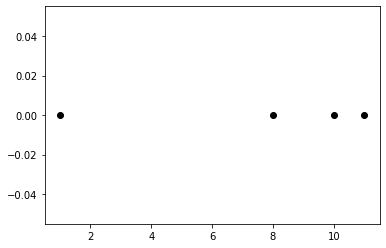

In [ ]:
x = [1, 8, 10, 11]
y = [0, 0, 0, 0]
plt.plot(x, y, 'o', color='black')

* If k were set to 2 in the above example, the 3 rightmost points would be in one cluster and the leftmost point would be in its own cluster
* Therefore, what we need are clusters of fixed size not a fixed number of clusters
* We will draw some inspiration from the k modes algorithm to design our own clustering algorithm which creates clusters of 2 instances
* For the similarity metric, we must consider how much weight to give to names, countries, cities, and topics
* Because the score from countries, cities, and topics falls in the same scale (0-1), the scale need not be changed
* We will give topics 1.2x as much weight as countries and cities because:
  * As calculated above, topics tells us that matching instances, on average, have a value 2.4x as as high as non-matching instances while cities and countries tell us that matching instances, on average, have a value 2x as high as non-matching instances
  * This means that topics is (2.4/2)=1.2x as informative as countries or cities
* Furthermore, in addition to removing from consideration those instances which have no instances in the other dataset with matching names, we will also calculate a score for names
* Somewhat counterintuitively, middle names are more informative than first names (because fewer people have them), so these will be given a higher weight
* As a heuristic, which could later be improved:
  * If the first names are both longer than 1 character and match exactly, the name score is incremented by 0.4
  * If one of them is only one character and they both match, the name score is incremented by 0.2
  * If the middle names are both longer than 1 character and match exactly, the name score is incremented by 0.6
  * If one of them is only one character and they both match, the name score is incremented by 0.3
* This proposed algorithm briefly works as follows:
  * The similarity between two instances: sim(x,y) = $\delta_m + \delta_n + \frac{1}{2}(\frac{1}{c_a}\sum_{j=1}^{c_a}f_{j,x,c} + \frac{1}{c_i}\sum_{j=1}^{c_i}f_{j,y,c}) + \frac{1}{2}(\frac{1}{u_a}\sum_{j=1}^{u_a}f_{j,x,u} + \frac{1}{u_i}\sum_{j=1}^{u_i}f_{j,y,u}) + 1.2(\frac{1}{t_i}\sum_{j=1}^{t_i}f_{j,y,t})$  
$f_{j,y,e} = 1 $ if $x_{e_j} \in y_e$, $f_{j,y,e} = 0 $ if $x_{e_j} \notin y_e$  
$f_{j,x,e} = 1 $ if $y_{e_j} \in x_e$, $f_{j,x,e} = 0 $ if $y_{e_j} \notin x_e$  
$\delta_e = 0.6$ if $e = m$ and $x_e = y_e$, $\delta_e = 0.3$ if $e = m$ and $x_e[0] = y_e[0]$  
$\delta_e = 0.4$ if $e = n$ and $x_e = y_e$, $\delta_e = 0.2$ if $e = n$ and $x_e[0] = y_e[0]$  
  * e in the equation above represents the different features of x and y
    * e = {m, n, c, u, t} = {middle name, first name, list of cities, list of cities, list of topics}
  * The similarity between two instances is set to 0 if the names explicitly do not match (meaning these instances cannot be in one cluster)
  * If an instance has 0 similarity with all other instances, it is removed from consideration
  1. Randomly select a point from one data source and pick the point with the highest similarity to it from the other data source as its cluster
  2. Remove the point and its most similar point from consideration
  3. Repeat steps 1 and 2 until there are no points remaining
  4. Calculate total variation among the clusters' similarity scores and keep an array with the clusters
  5. Repeat steps 1 through 4 a fixed number of times to get the clustering with the minimum total variation among the clusters' similarity scores
* The code below implements the algorithm so that it is not dependent on the previous cells of code (excluding the code cell where the filepaths of the csv files are specified)
* The fixed number of times to run the algorithm to find the best matches is currently set to 5 using the "runs" variable

In [ ]:
"""
Importing data from CSV.
"""

# investigators csv read into pandas dataframe
df_investigators = pd.read_csv(investigator_path, 
                               encoding='latin-1')
df_investigators.columns = range(df_investigators.shape[1])
inv_ids = []
# authors csv read into pandas dataframe
df_authors = pd.read_csv(author_path, encoding='latin-1')
df_authors.columns = range(df_authors.shape[1])
# df_input is concatenation of investigators data to authors data
df_input = pd.concat([df_authors, df_investigators], axis=0)
df_input = df_input.reset_index()
# creating 2d list of coauthor and coinvestigator last names
co_names_arr = []
for i in df_input[4]:
  line_arr = []
  if i.find('\"') < 0:
    co_names_arr.append(line_arr)
    continue
  else:
    start_ind = i.find('\"')
    while start_ind >= 0:
      end_ind = i.find('\"', start_ind+1)
      line_arr.append(i[start_ind: end_ind+1])
      start_ind = i.find('\"', end_ind+1)
  co_names_arr.append(line_arr)
# creating 2d list of topics
topics_arr = []
for i in df_input[5]:
  line_arr = []
  if i.find('\"') < 0:
    topics_arr.append(line_arr)
    continue
  else:
    start_ind = i.find('\"')
    while start_ind >= 0:
      end_ind = i.find('\"', start_ind+1)
      line_arr.append(i[start_ind: end_ind+1])
      start_ind = i.find('\"', end_ind+1)
  topics_arr.append(line_arr)
# creating 2d list of cities
cities_arr = []
for i in df_input[6]:
  line_arr = []
  if i[i.find('identifier')+12] == 'n':
    cities_arr.append(line_arr)
    continue
  else:
    start_ind = i.find('identifier')+12
    while start_ind >= 12:
      end_ind = i.find(',', start_ind+1)
      line_arr.append(i[start_ind: end_ind])
      start_ind = i.find('identifier', end_ind+1)+12
  cities_arr.append(line_arr)
# creating 2d list of countries
countries_arr = []
for i in df_input[7]:
  line_arr = []
  if i[i.find('identifier')+12] == 'n':
    countries_arr.append(line_arr)
    continue
  else:
    start_ind = i.find('identifier')+12
    while start_ind >= 12:
      end_ind = i.find(',', start_ind+1)
      line_arr.append(i[start_ind: end_ind])
      start_ind = i.find('identifier', end_ind+1)+12
  countries_arr.append(line_arr)

"""
Recording which indices belong to the author dataset and which belong to the
investigator dataset.
"""

investigator_indices = []
author_indices = []
for i in range(len(df_input[0])):
  # the rows in the dataframe which correspond to author data
  if i < 1019:
    author_indices.append(i)
  # the rows in the dataframe which correspond to investigator data
  else:
    investigator_indices.append(i)

"""
Algorithm begins here.
"""

def pairwise_clustering():
  matches = {}
  # copy investigator and author indices
  c_investigator_indices = investigator_indices.copy()
  c_author_indices = author_indices.copy()
  while(len(c_investigator_indices) > 0):
    index = random.randint(0, len(c_investigator_indices)-1)
    # random investigator instance chosen
    i = c_investigator_indices[index]
    # investigator instance removed so that it can not be used in future clusters
    c_investigator_indices.remove(i)
    name_match = False
    sim_scores = {}
    rejects = []
    # compare investigator instance to all author instances
    for a in c_author_indices:
      country_score = 0
      city_score = 0
      topic_score = 0
      name_score = 0
      last = True
      middle = True
      first = True
      # if the last names do not exactly match
      if df_input[3][i] != df_input[3][a]:
        last = False
      # if these are non-NaN values
      investigator_first = df_input[1][i]
      author_first = df_input[1][a]
      if str(investigator_first) != 'nan' and str(author_first) != 'nan':
        # remove periods
        if investigator_first.find('.') >= 0:
          investigator_first = investigator_first.replace('.','')
        if author_first.find('.') >= 0:
          author_first = author_first.replace('.','')
        if len(author_first) > 0 and len(investigator_first) > 0:
          # if the length of either the investigator or author first name is 1
          if len(investigator_first) == 1 or len(author_first) == 1:
            # if the first characters of the first names do not match
            if not investigator_first[0] == author_first[0]:
              first = False
            else:
              # if the first characters of the first names match
              name_score += 0.2
          # otherwise
          elif len(investigator_first) > 1 and len(author_first) > 1:
            # if the first names do not match
            if not investigator_first == author_first:
              first = False
            else:
              # if the first names match
              name_score += 0.4
      # if these are non-NaN values
      investigator_middle = df_input[2][i]
      author_middle = df_input[2][a]
      if str(investigator_middle) != 'nan' and str(author_middle) != 'nan':
        # remove periods
        if investigator_middle.find('.') >= 0:
          investigator_middle = investigator_middle.replace('.','')
        if author_middle.find('.') >= 0:
          author_middle = author_middle.replace('.','')
        if len(author_middle) > 0 and len(investigator_middle) > 0:
          # if the length of either the investigator or author middle name is 1
          if len(investigator_middle) == 1 or len(author_middle) == 1:
            # if the first characters of the middle names do not match
            if investigator_middle[0] != author_middle[0]:
              middle = False
            # if the first characters of the middle names match
            else:
              name_score += 0.3
          # otherwise
          elif len(investigator_middle) > 1 and len(author_middle) > 1:
            # if the middle names do not match
            if investigator_middle != author_middle:
              middle = False
            # if the middle names match
            else:
              name_score += 0.6
      # if any of the first, middle, or last names do not match as described,
      # reject these author instances
      if not first or not middle or not last:
        rejects.append(a)
      else:
        name_match = True
    # if this investigator instance has no author instances which have matching
    # names, then the investigator instance is discarded from consideration for
    # clustering
    if len(rejects) == len(c_author_indices):
      continue
    else:
      for a in c_author_indices:
        # we now compare the topics, cities, and countries lists between the
        # investigator instance and non-rejected author instances
        if a not in rejects:
          count = 0
          true_count = 0
          # check the percentage of countries found in the investigator list that
          # are present in the author list
          for j in countries_arr[i]:
            if j in countries_arr[a]:
              true_count += 1
            count += 1
          if count > 0:
            country_score = true_count/count
          else:
            # if the array is empty, percentage = 100%
            country_score = 1
          count = 0
          true_count = 0
          # check the percentage of countries found in the author list that are
          # present in the investigator list
          for k in countries_arr[a]:
            if k in countries_arr[i]:
              true_count += 1
            count += 1
          # the percentages are averaged here
          if count > 0:
            country_score = (country_score+(true_count/count))/2
          else:
            country_score = (country_score+1)/2
          
          count = 0
          true_count = 0
          # calculate the average percent of cities present in both the author
          # and investigator instances
          for j in cities_arr[i]:
            if j in cities_arr[a]:
              true_count += 1
            count += 1
          if count > 0:
            city_score = true_count/count
          else:
            city_score = 1
          count = 0
          true_count = 0
          for k in cities_arr[a]:
            if k in cities_arr[i]:
              true_count += 1
            count += 1
          if count > 0:
            city_score = (city_score+(true_count/count))/2
          else:
            city_score = (city_score+1)/2
          
          count = 0
          true_count = 0
          # check what percentage of the topics in the investigator instance are
          # in the author instance
          for j in topics_arr[i]:
            if j in topics_arr[a]:
              true_count += 1
            count += 1
          if count > 0:
            topic_score = true_count/count
          else:
            topic_score = 1
          # total score calculated
          sim_scores[a] = name_score+country_score+city_score+1.2*topic_score
    # the author instance with the maximum similarity to the investigator instance
    # is selected
    max_score_index = -1
    max_score = 0
    for s in sim_scores:
      curr_score = sim_scores[s]
      if curr_score > max_score:
        max_score = curr_score
        max_score_index = s
    if max_score_index == -1:
      continue
    matches[(i-1018,max_score_index+1)] = max_score
    # the matched author instance is then removed from consideration for future
    # clusters
    c_author_indices.remove(max_score_index)
  # the standard deviation in similarity scores for all the matches is calculated
  all_sims = []
  only_matches = []
  for m in matches:
    all_sims.append(matches[m])
    only_matches.append(m)
  only_matches = tuple(only_matches)
  if len(all_sims) == 1:
    all_matches[only_matches] = 0
  else:
    all_matches[only_matches] = stat.stdev(all_sims)

all_matches = {}
# number of times to run algorithm to get best clustering is set here
runs = 5
threads = []
# creates a thread to call create a clustering for each iteration
# should speed up by approx. a factor of the number of cores
for run in range(runs):
  t = Thread(target=pairwise_clustering, args=())
  t.start()
  threads.append(t)
for t in threads:
  t.join()

# the clustering with the least standard deviation is selected as the best clustering
# of matching instances
least_stdev = 1000
best_matches = []
for element in all_matches:
  curr_stdev = all_matches[element]
  if curr_stdev < least_stdev:
    least_stdev = curr_stdev
    best_matches = element
print("ids of matching instances:")
for b in best_matches:
  print(b)

ids of matching instances:
(221, 230)
(28, 31)
(286, 327)
(518, 621)
(84, 92)
(567, 686)
(246, 849)
(561, 679)
(440, 507)
(531, 639)
(451, 530)
(277, 312)
(171, 171)
(629, 753)
(755, 892)
(713, 850)
(670, 806)
(594, 720)
(377, 433)
(17, 18)
(397, 910)
(336, 377)
(520, 624)
(598, 728)
(285, 326)
(129, 144)
(160, 164)
(312, 356)
(555, 670)
(41, 345)
(791, 939)
(256, 285)
(270, 304)
(232, 252)
(29, 32)
(819, 969)
(602, 730)
(355, 404)
(39, 45)
(59, 65)
(612, 742)
(298, 342)
(496, 460)
(201, 617)
(587, 706)
(623, 746)
(245, 266)
(787, 538)
(343, 386)
(674, 810)
(204, 202)
(64, 68)
(389, 454)
(410, 473)
(46, 51)
(335, 376)
(553, 369)
(407, 470)
(836, 1018)
(112, 119)
(158, 162)
(111, 118)
(423, 486)
(142, 682)
(537, 647)
(275, 310)
(795, 943)
(269, 302)
(798, 947)
(793, 941)
(672, 441)
(724, 871)
(317, 361)
(736, 882)
(157, 159)
(754, 891)
(462, 556)
(481, 577)
(19, 19)
(711, 410)
(470, 566)
(213, 215)
(533, 642)
(718, 854)
(144, 143)
(688, 825)
(439, 506)
(665, 800)
(259, 286)
(179, 177)
(

* The code in the cell above outputs the ids of the matching instances and takes around 2 minutes to run (with 5 set as the number of iterations)
* The output of the algorithm is non-deterministic (it is not guaranteed to remain the same each time given the same input)
* Let us now assess the accuracy of our algorithm by calculating the percentage of ids of actual matching instances which are present in the matching instances our algorithm outputs

## Conclusion

In [ ]:
true_count = 0
for m in matching_indices:
  if m in best_matches:
    true_count += 1
print("accuracy: " + str(100*(true_count/len(matching_indices))) + "%")

accuracy: 98.05825242718447%


* Even with a low number of iterations, the algorithm almost always achieves 98%+ accuracy
* With a higher number of iterations, this accuracy will likely increase, but so will the run time
* The algorithm has a worst-case time complexity of $O(n^4)$
* To further speed up the code, certain modifications could be made:
  * Numpy object arrays could be used place of Pandas dataframes, as the columnar access time for numpy arrays is typically significantly faster than for Pandas dataframes
  * Parallelization could be utlized where applicable
    * For example, it could be used when calculating the variation among clusters in different clusterings or when calculating city, country, and topic scores
* To possibly further boost accuracy and help the algorithm generalize to new data, the following could be explored:
  * The percentage of consecutive matching characters in the first name and middle name could be used instead of the current scheme
  * Different weights for the different sub-scores of the total similarity score could be tried using a grid search approach
  * All unwanted substrings can be removed from features